In [4]:
import itertools
import numpy as np
import pandas as pd
import pickle
import random
import requests
import seaborn as sns
import os

from IPython.display import display
from matplotlib import pyplot as plt
from math import sqrt
from scipy.stats import uniform
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from typing import Any, Dict, List, Tuple, Union, Optional
from xgboost import XGBClassifier

from microservice import IUMModel
from utility import (
    load_data,
    get_buckets_indices,
    get_s_p,
    get_t,
    get_xgb_logreg_f1_scores,
    is_xgb_better,
    BUCKETS_CNT,
    T_ALPHA,
    Model,
    ArrayLike
)

Wybrane cechy

In [5]:
FEATURE_VERSION = 'v1'
FEATURE_PATH = f'features/{FEATURE_VERSION}/feature.csv'

FEATURES = [
    'number_of_advertisements',
    'number_of_tracks',
    'number_of_skips',
    'number_of_likes',
    'number_of_liked_tracks_listened',
    'number_of_tracks_in_favourite_genre',
    'total_number_of_favourite_genres_listened',
    'average_popularity_in_favourite_genres',
    'total_tracks_duration_ms',
    'number_of_different_artists',
    'average_release_date',
    'average_duration_ms',
    'explicit_tracks_ratio',
    'average_popularity',
    'average_acousticness',
    'average_danceability',
    'average_energy',
    'average_instrumentalness',
    'average_liveness',
    'average_loudness',
    'average_speechiness',
    'average_tempo',
    'average_valence',
    'average_track_name_length',
    'average_daily_cost',
]

TARGETS = [
    'premium_user_numerical',
    'will_buy_premium_next_month_numerical'
]

TARGET_AND_FEATURES = TARGETS + FEATURES

In [6]:
data_frame = pd.read_csv(FEATURE_PATH)

In [7]:
data_frame.head()

,user_id,year,month,premium_user_numerical,will_buy_premium_next_month_numerical,number_of_premium,number_of_advertisements,number_of_tracks,number_of_skips,number_of_likes,...,average_danceability,average_energy,average_instrumentalness,average_liveness,average_loudness,average_speechiness,average_tempo,average_valence,average_track_name_length,average_daily_cost
0,212,2020,2,1,0,0,10,30,16,8,...,0.542767,0.600467,0.094653,0.179113,-10.158167,0.049070,121.964467,0.588167,22.233333,0.012134
1,212,2020,7,1,0,0,5,16,8,2,...,0.499000,0.675250,0.150966,0.226225,-8.795062,0.061812,123.069063,0.452131,22.687500,0.014780
2,212,2020,1,1,0,0,14,39,21,12,...,0.487000,0.691667,0.119363,0.235690,-9.491795,0.064918,123.745769,0.564369,19.461538,0.012399
3,212,2020,3,1,0,0,3,20,9,6,...,0.516700,0.637150,0.069641,0.189545,-8.409150,0.053715,121.415600,0.586000,21.250000,0.012706
4,212,2020,8,1,0,0,13,40,22,12,...,0.513525,0.642350,0.112645,0.285203,-9.562400,0.055282,120.922325,0.510517,24.000000,0.013076


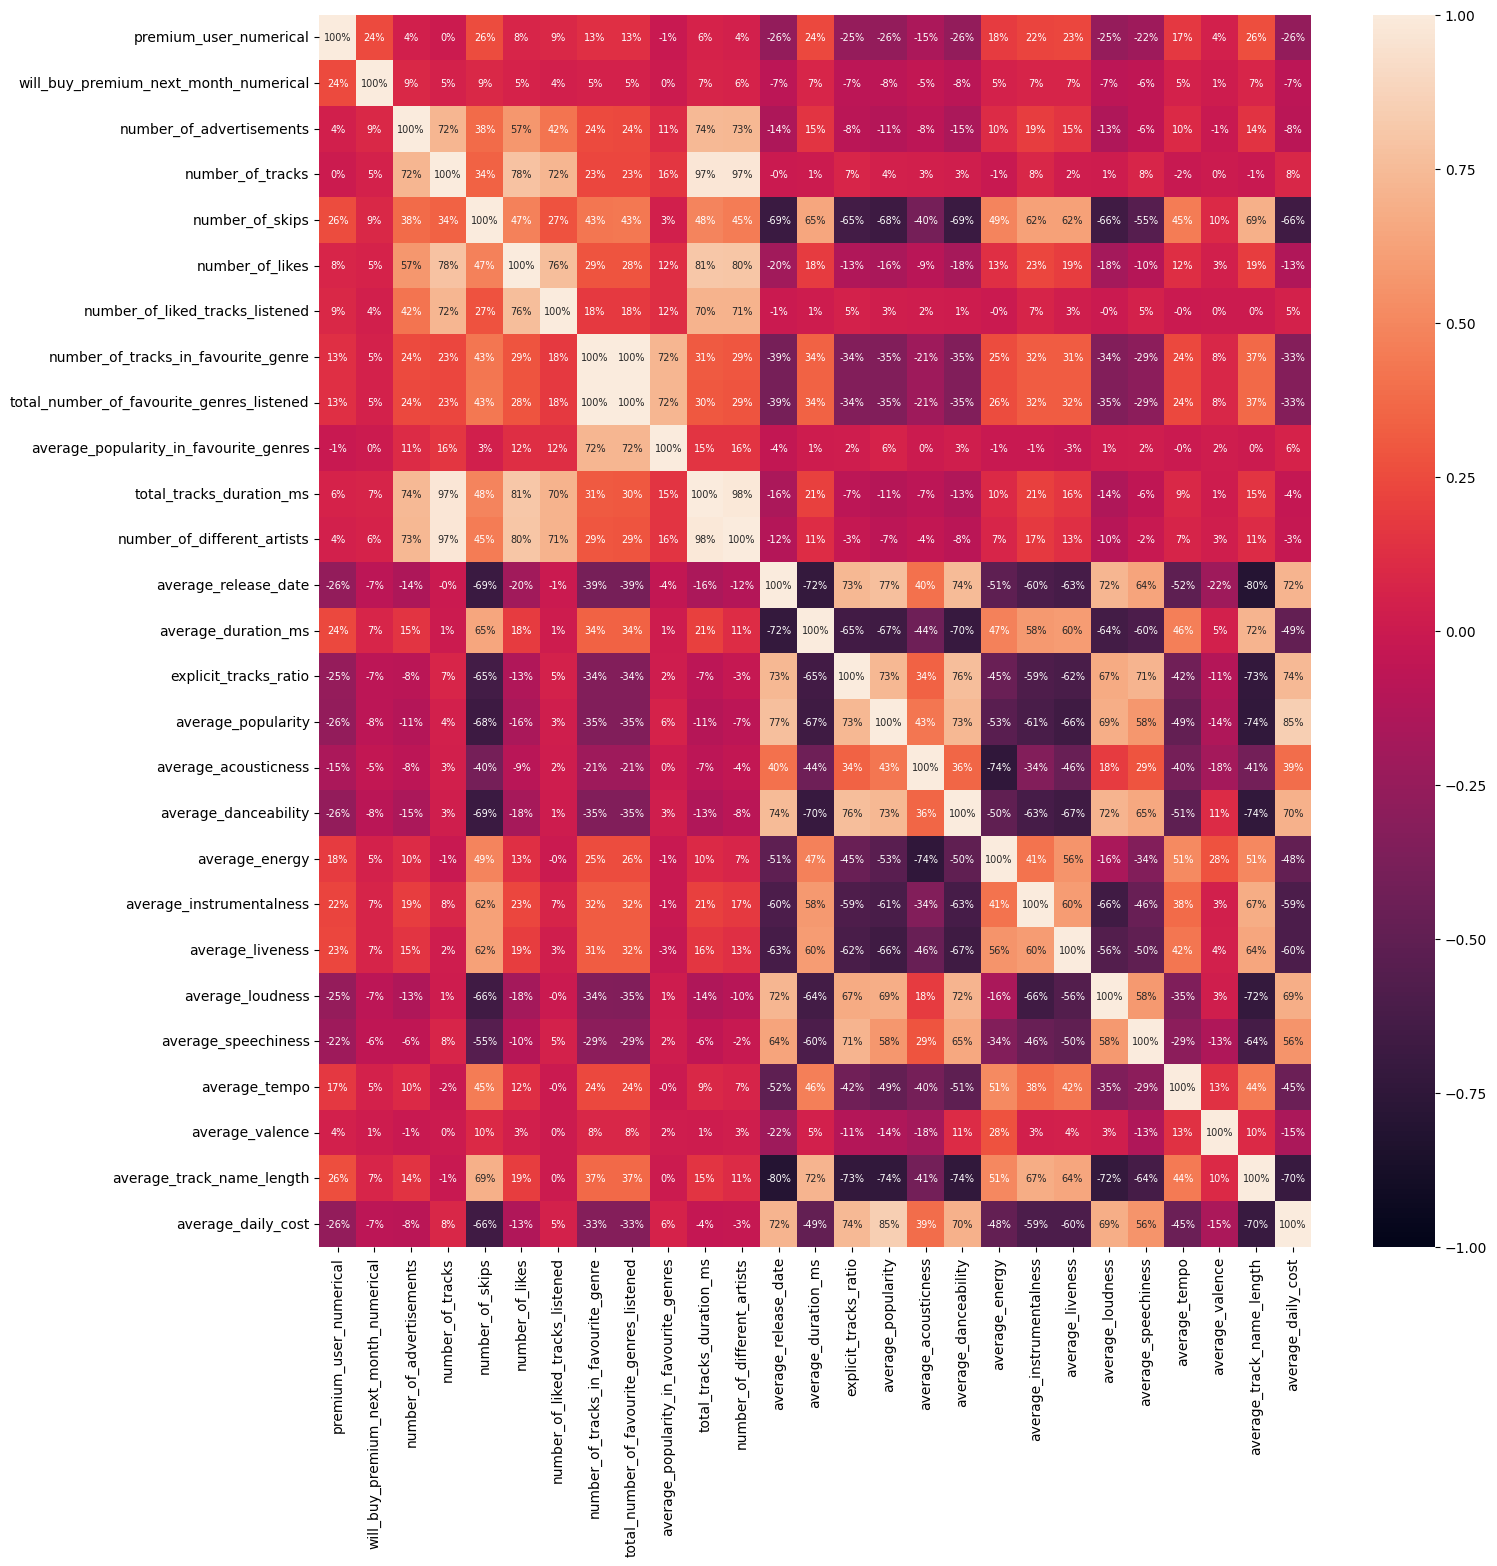

In [8]:
correlation_matrix = data_frame.loc[:, TARGET_AND_FEATURES] \
    .corr(method='spearman')

plt.figure(figsize=(16, 16))

sns.heatmap(
    correlation_matrix,
    xticklabels=correlation_matrix.columns,  # type: ignore
    yticklabels=correlation_matrix.columns,  # type: ignore
    annot=True,
    annot_kws={"fontsize": 7},
    fmt=".0%",
    vmin=-1,
    vmax=1,
)

plt.show()

Definiujemy pipeline do uzupełnienia danych pustych oraz przeskalowania danych

In [9]:
pipeline = Pipeline([
    ("simple_imputer", SimpleImputer()),
    ("standard_scaler", StandardScaler())
])

Dzielimy dane na dane trenujące oraz testowe do późniejszych eksperymentów A/B

In [10]:
TRAINING_UP_TO = 2023
TRAIN_DATA: pd.DataFrame = data_frame.loc[data_frame.year < TRAINING_UP_TO, :]
TEST_DATA: pd.DataFrame = data_frame.loc[data_frame.year >= TRAINING_UP_TO, :]
TEST_SIZE = 0.33

pipeline dobieramy na podstawie samych danych testowych


In [11]:
X_train_temp, X_test_temp, Y_train, Y_test = train_test_split(
    TRAIN_DATA[FEATURES],
    TRAIN_DATA[TARGETS],
    test_size=TEST_SIZE
)
X_train_temp: pd.DataFrame
X_test_temp: pd.DataFrame
Y_train: pd.DataFrame
Y_test: pd.DataFrame

train_data = pipeline.fit_transform(X_train_temp)
test_data = pipeline.transform(X_test_temp)
X_train = pd.DataFrame(train_data, columns=FEATURES)
X_test = pd.DataFrame(test_data, columns=FEATURES)

In [12]:
X_train.head()

,number_of_advertisements,number_of_tracks,number_of_skips,number_of_likes,number_of_liked_tracks_listened,number_of_tracks_in_favourite_genre,total_number_of_favourite_genres_listened,average_popularity_in_favourite_genres,total_tracks_duration_ms,number_of_different_artists,...,average_danceability,average_energy,average_instrumentalness,average_liveness,average_loudness,average_speechiness,average_tempo,average_valence,average_track_name_length,average_daily_cost
0,1.629423,1.175016,1.676029,2.530704,1.245504,-0.079437,-0.120468,0.138856,1.400003,1.411291,...,-1.228868,0.696177,1.101064,1.112566,-1.203939,-0.903375,-0.276071,0.032879,1.194219,-1.143756
1,0.383962,0.784407,-0.712230,0.858390,1.440299,-0.455365,-0.446958,1.395704,0.658321,0.813743,...,0.492499,-0.035511,-0.726937,-0.843525,0.960731,-0.151098,-0.551007,-0.130491,-1.022692,0.363997
2,1.629423,1.175016,2.358389,1.694547,0.855915,-0.267401,-0.283713,0.438566,1.471290,1.172272,...,-1.319603,0.496280,1.369963,-0.036136,-1.150676,-0.925218,1.950524,-0.019871,0.629016,-1.104473
3,0.633054,0.296146,0.993670,0.022234,-0.312852,-0.455365,-0.446958,0.032507,0.404952,0.335704,...,-1.256285,0.684640,1.848513,1.094659,-0.874002,-1.026700,0.648648,-0.151564,0.961293,-1.109312
4,0.134870,-0.680376,-0.882820,-1.371361,-0.312852,0.860383,0.695754,1.497218,-0.851732,-0.739882,...,1.350251,-0.160905,-0.718478,-0.872766,0.956886,-0.980641,-1.739467,0.853302,-1.093213,0.913188


In [13]:
Y_train.head()

,premium_user_numerical,will_buy_premium_next_month_numerical
85548,0,0
147444,0,0
30681,0,0
77366,0,0
57973,0,0


In [14]:
DUMMY = 'dummy'
LOGISTIC_REG = 'logistic_regression'
XGB = 'xgb_classifier'
XGB_BEST_ESTIMATOR = 'xgb_classifier_best_estimator'
RANDOM = 'randomized_search'


MODEL_TYPES = [DUMMY, LOGISTIC_REG, XGB, XGB_BEST_ESTIMATOR]


def construct_dummy(X_train: pd.DataFrame, y_train: pd.DataFrame, params: Optional[Dict[str, Any]] = None) -> DummyClassifier:
    return DummyClassifier().fit(X_train, y_train)


def construct_logistic_reggression(X_train: pd.DataFrame, y_train: pd.DataFrame, params: Optional[Dict[str, Any]] = None) -> LogisticRegression:
    return LogisticRegression().fit(X_train, y_train)


def construct_xgb_classifier(X_train: pd.DataFrame, y_train: pd.DataFrame, params: Optional[Dict[str, Any]] = None) -> XGBClassifier:
    return XGBClassifier().fit(X_train, y_train)


def construct_xgb_classifier_with_randomized_search(X_train: pd.DataFrame, y_train: pd.DataFrame, params: Optional[Dict[str, Any]] = None) -> XGBClassifier:
    scale = y_train.value_counts()
    if params:
        return XGBClassifier(**params).fit(X_train, y_train)
    model = XGBClassifier(scale_pos_weight=sqrt(scale[0] / scale[1]))
    # TODO: update with own parameters

    randomized_search_cv = RandomizedSearchCV(
        estimator=model,
        param_distributions={
            'max_depth': range(3, 30),  # range(3, 30),
            'eta': uniform(0, 0.2),
            'gamma': uniform(0, 1),
            'n_estimators': range(10, 100),
        },
        # param_distributions={
        #     'max_depth': np.arange(3, 30, 1),
        #     'eta': uniform(0, 0.1),
        #     'gamma': uniform(0, 1),
        #     'n_estimators': np.arange(10, 100, 1),
        # },
        n_iter=1,  # 20,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=3,
    )
    estimator = randomized_search_cv.fit(X_train, y_train)
    return estimator.best_estimator_  # type: ignore


MODEL_CONSTRUCTORS = {
    DUMMY: construct_dummy,
    LOGISTIC_REG: construct_logistic_reggression,
    XGB: construct_xgb_classifier,
    XGB_BEST_ESTIMATOR: construct_xgb_classifier_with_randomized_search
}
MODELS: Dict[str, Dict[str, Model]] = {}

for type in MODEL_TYPES:
    MODELS[type] = {
        target: MODEL_CONSTRUCTORS[type](X_train, Y_train[target])
        for target in TARGETS
    }

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 2/5] END eta=0.25370755369755693, gamma=0.6695493125104817, max_depth=11, n_estimators=97;, score=0.690 total time= 3.7min
[CV 5/5] END eta=0.25370755369755693, gamma=0.6695493125104817, max_depth=11, n_estimators=97;, score=0.695 total time= 3.7min
[CV 4/5] END eta=0.25370755369755693, gamma=0.6695493125104817, max_depth=11, n_estimators=97;, score=0.690 total time= 3.7min
[CV 3/5] END eta=0.25370755369755693, gamma=0.6695493125104817, max_depth=11, n_estimators=97;, score=0.691 total time= 3.7min
[CV 1/5] END eta=0.25370755369755693, gamma=0.6695493125104817, max_depth=11, n_estimators=97;, score=0.699 total time= 3.7min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END eta=0.02737791298428437, gamma=0.35798699707335, max_depth=29, n_estimators=30;, score=0.662 total time= 3.7min
[CV 5/5] END eta=0.02737791298428437, gamma=0.35798699707335, max_depth=29, n_estimators=30;, score=0.685 total time= 3.8m

DUMMY
ROC AUC score for premium_user_numerical: 0.5
ROC AUC score for will_buy_premium_next_month_numerical: 0.5


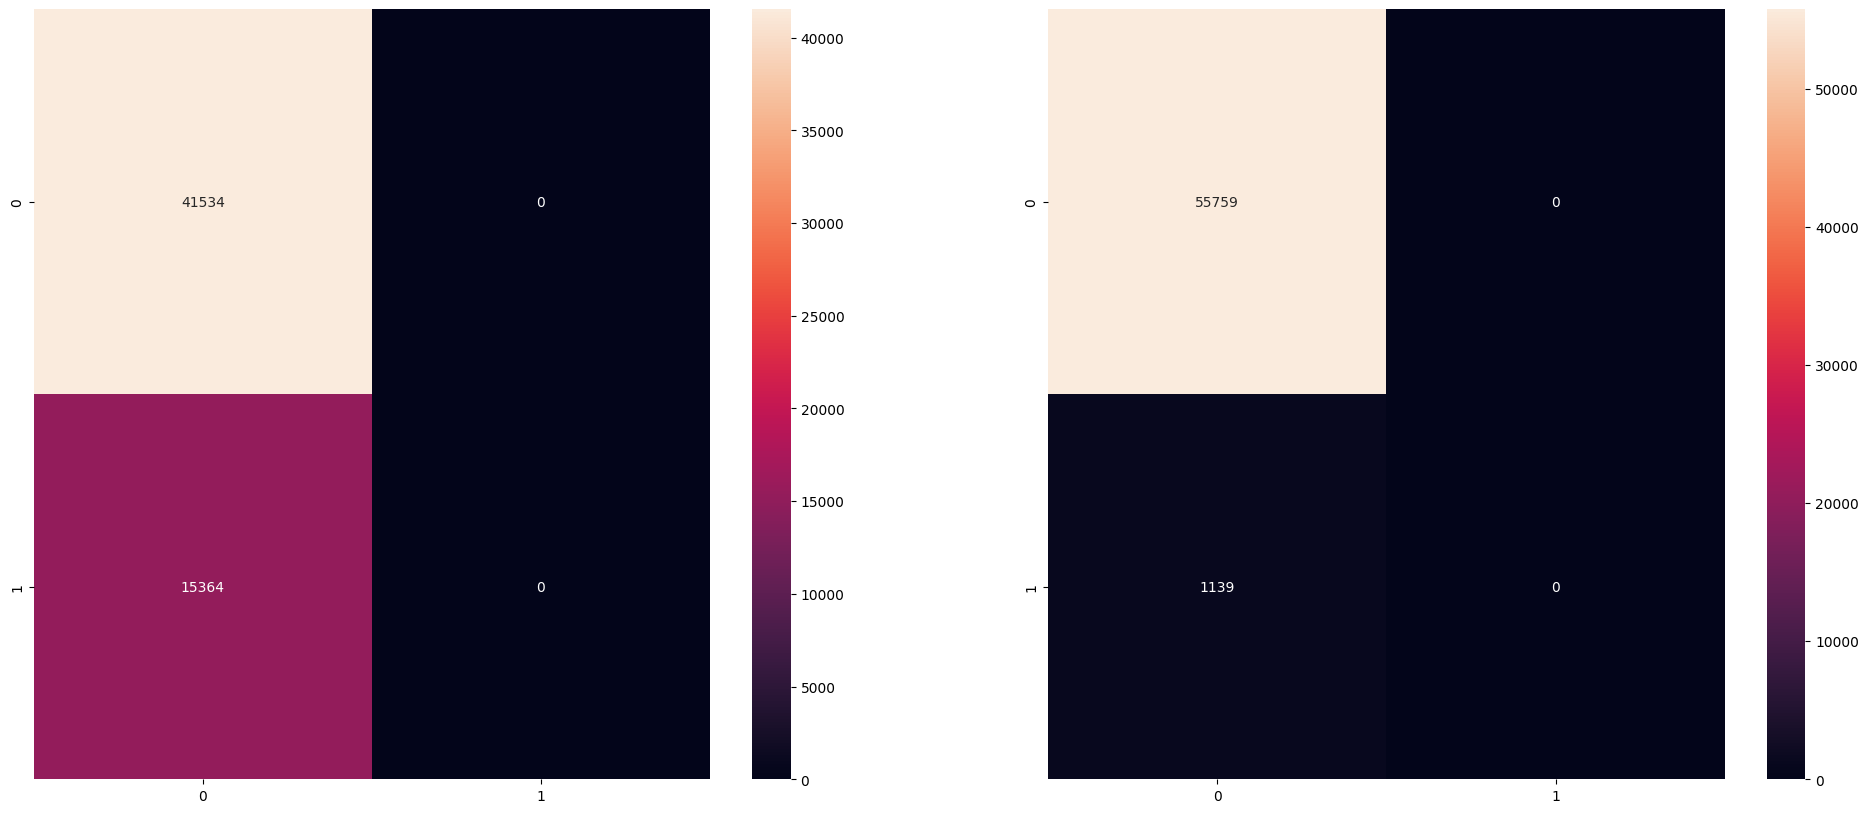

LOGISTIC_REGRESSION
ROC AUC score for premium_user_numerical: 0.5174468217034749
ROC AUC score for will_buy_premium_next_month_numerical: 0.5


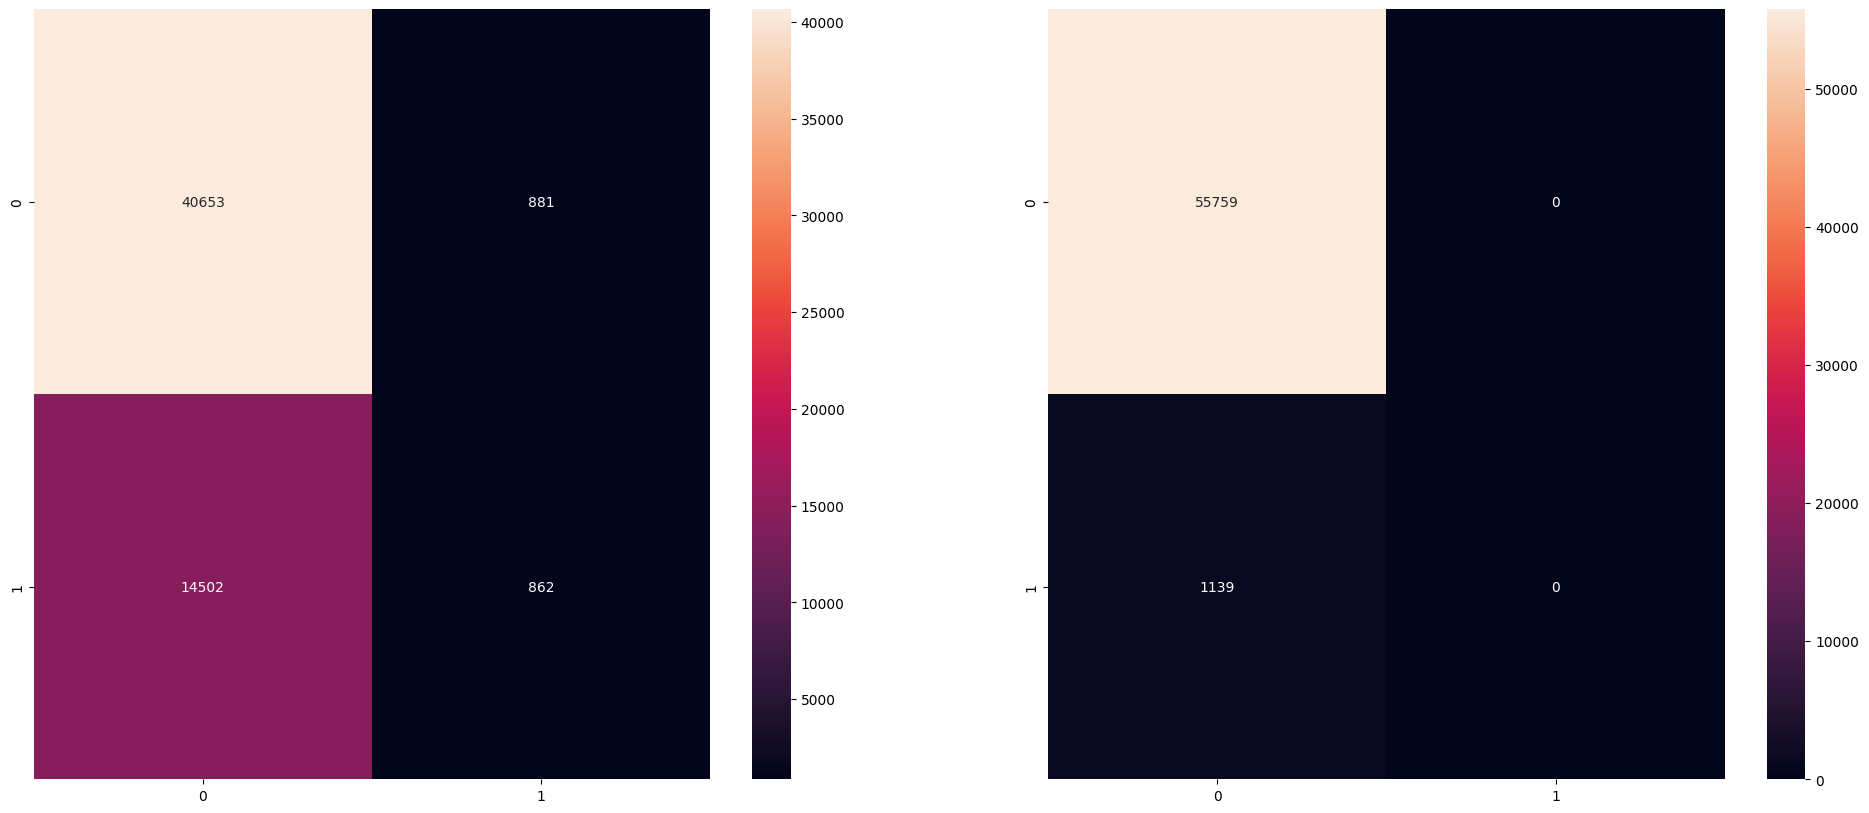

XGB_CLASSIFIER
ROC AUC score for premium_user_numerical: 0.5349380231917472
ROC AUC score for will_buy_premium_next_month_numerical: 0.5066201827030573


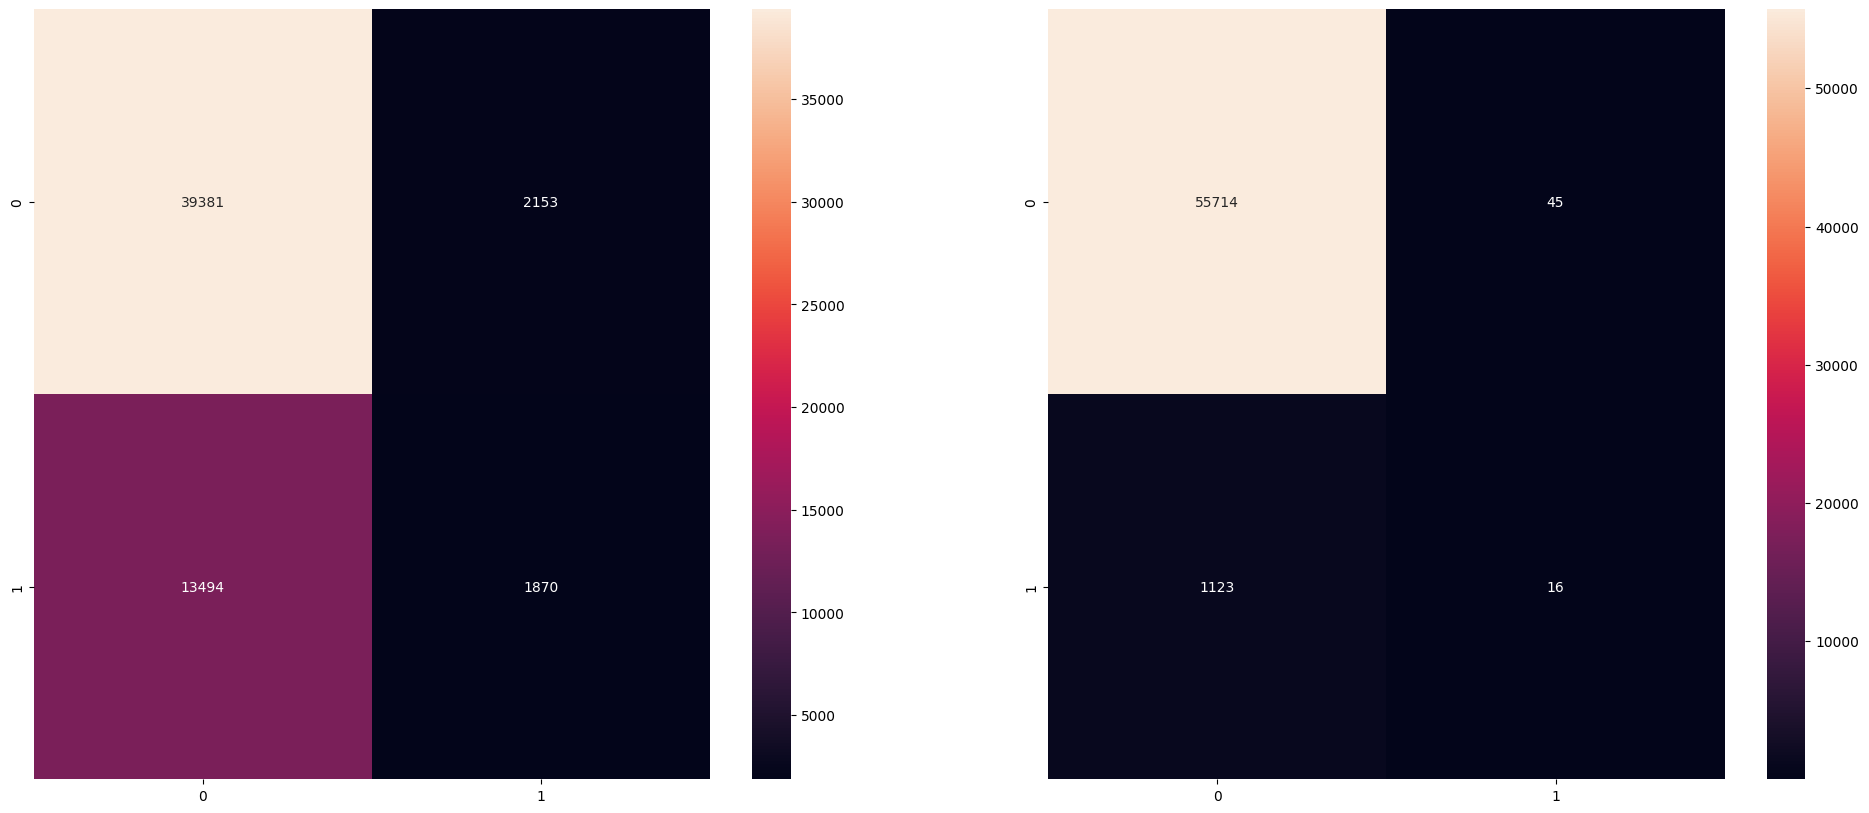

XGB_CLASSIFIER_BEST_ESTIMATOR
ROC AUC score for premium_user_numerical: 0.6099958780080953
ROC AUC score for will_buy_premium_next_month_numerical: 0.5348735459281911


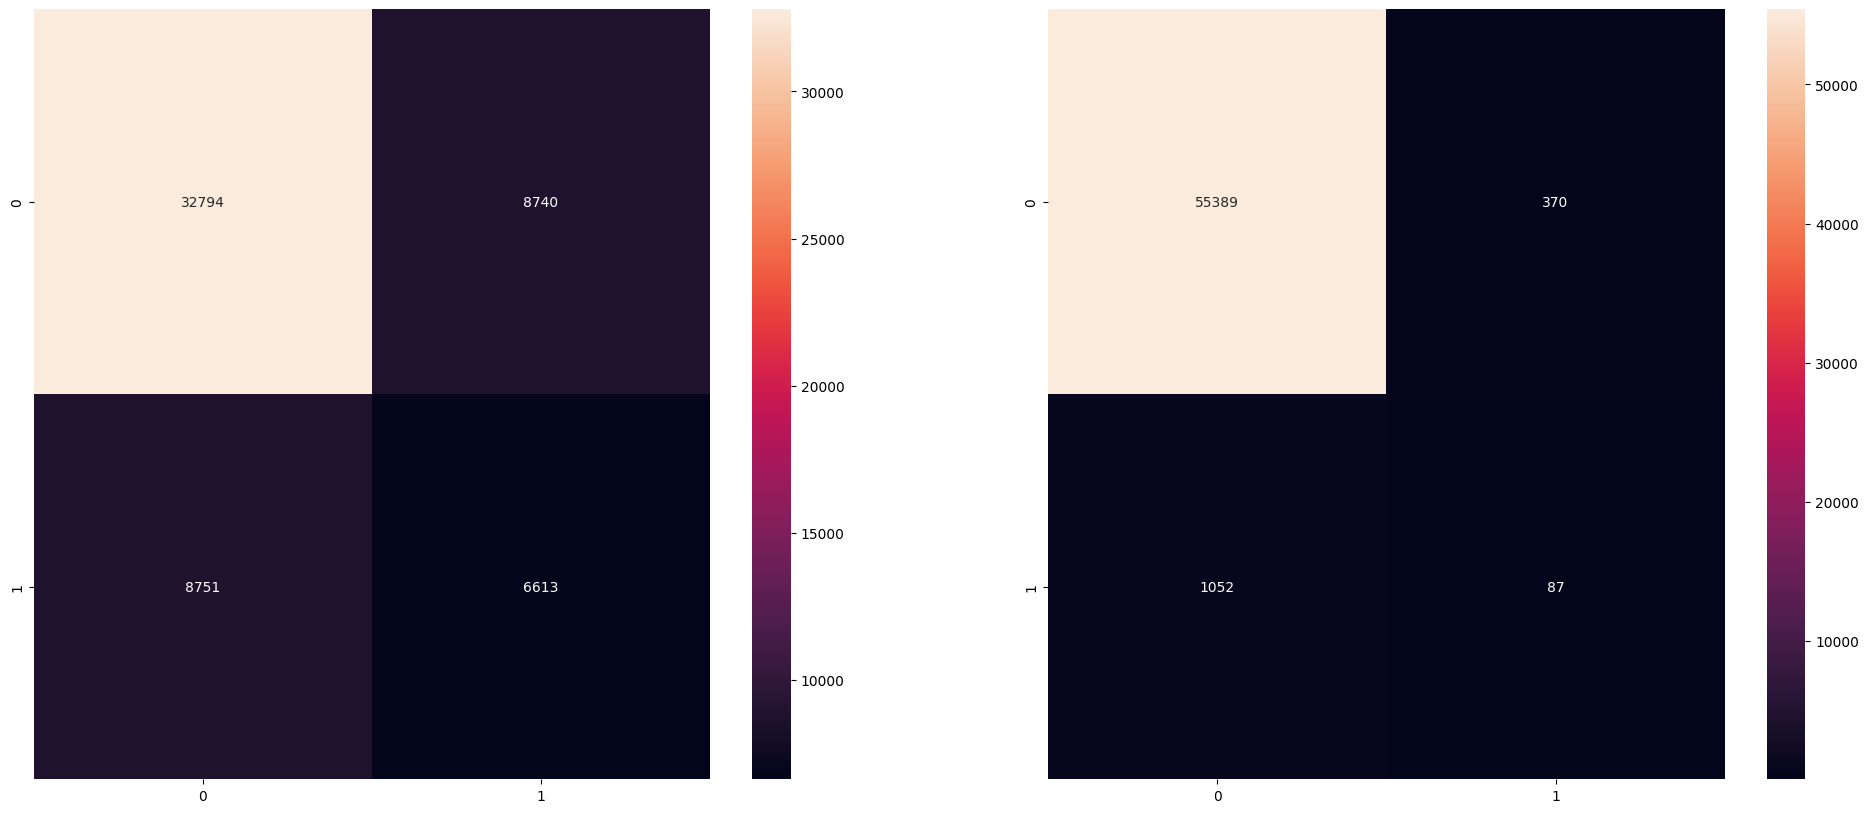

In [15]:
for type in MODEL_TYPES:
    print(type.upper())
    _, axs = plt.subplots(1, 2, figsize=(24, 10))  # type: ignore
    for i, target in enumerate(TARGETS):
        model = MODELS[type][target]
        y_predicted = model.predict(X_test)
        y_true = Y_test[target]
        roc_auc_score_value = roc_auc_score(y_true, y_predicted)
        print(f"ROC AUC score for {target}: {roc_auc_score_value}")
        matrix = confusion_matrix(y_true, y_predicted)
        sns.heatmap(
            matrix,
            annot=True,
            # annot_kws={"fontsize": 30},
            fmt='g',
            xticklabels=["0", "1"],  # type: ignore
            yticklabels=["0", "1"],  # type: ignore
            ax=axs[i]  # type: ignore
        )
    plt.show()

ważność parametrów

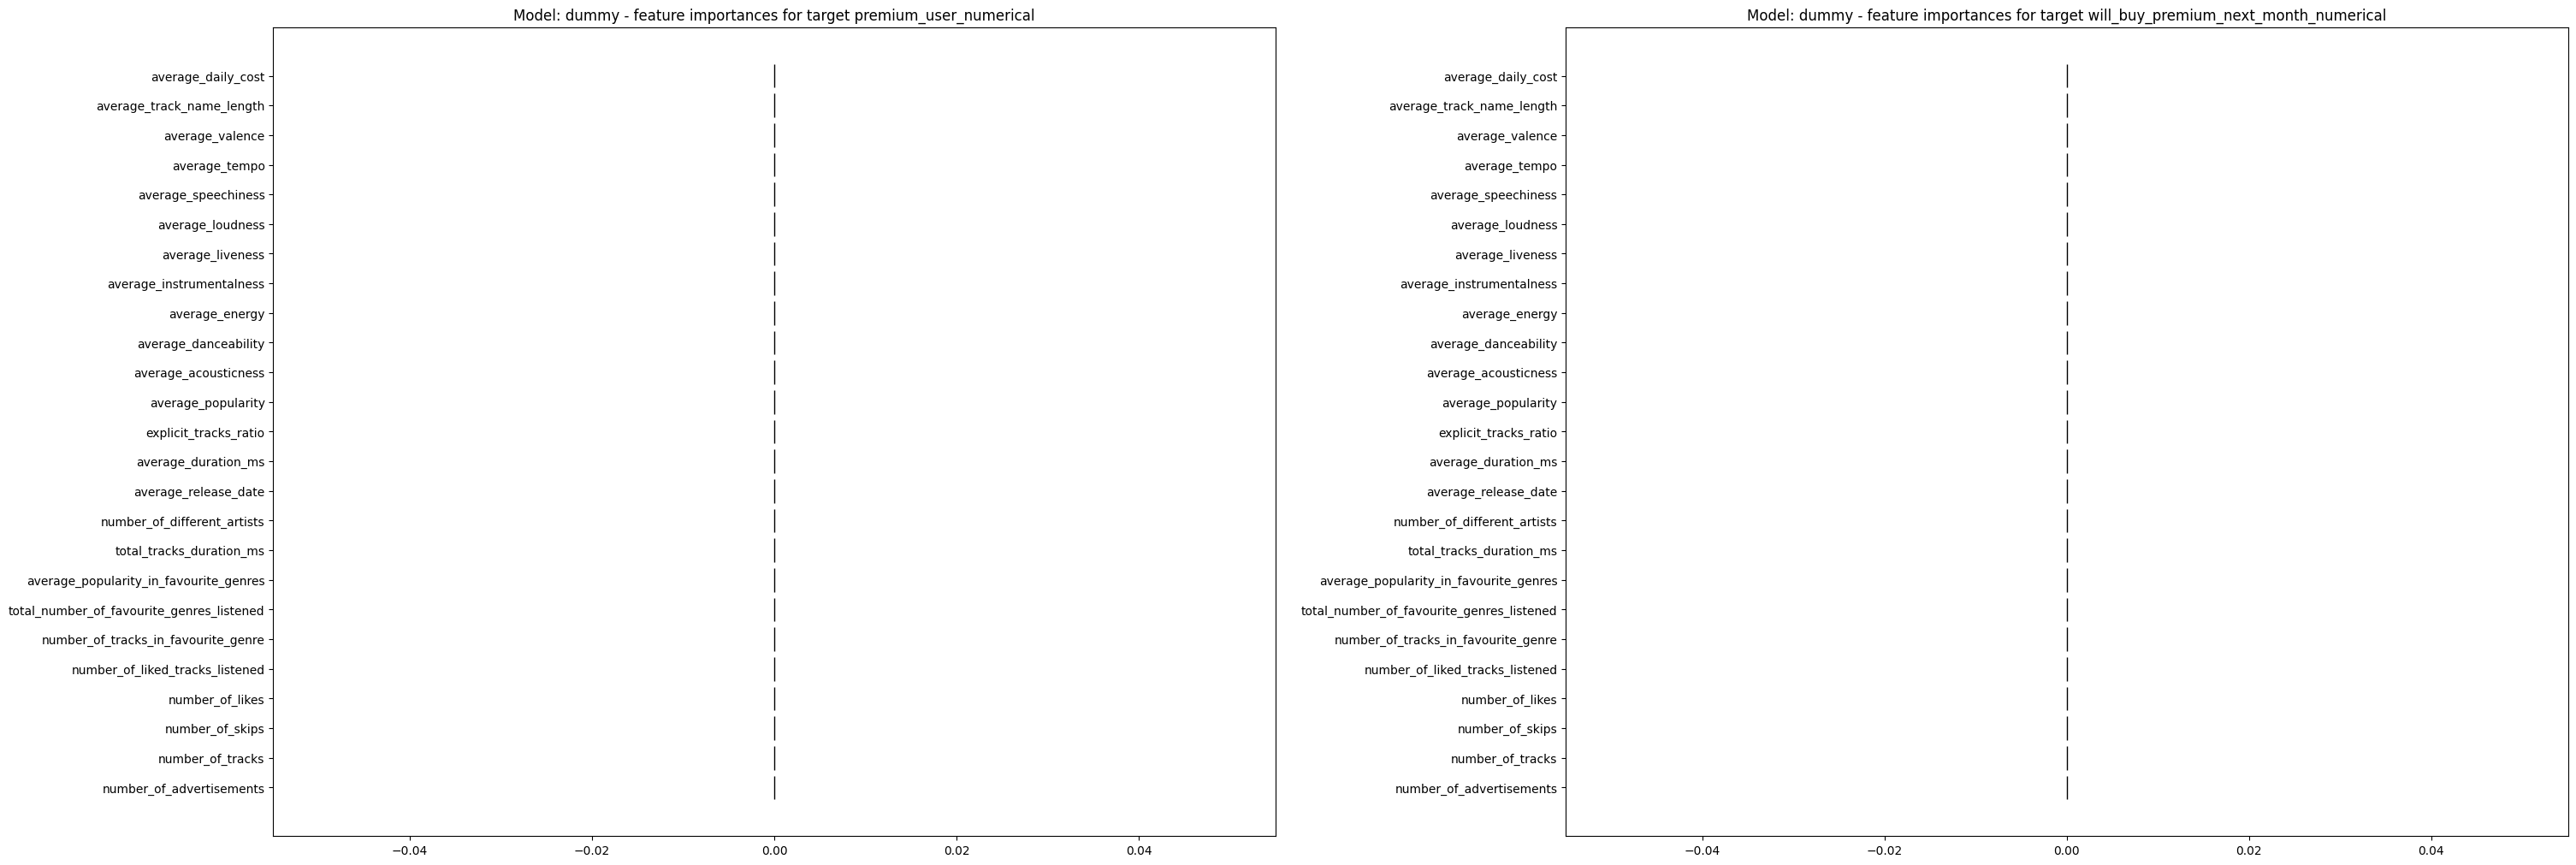

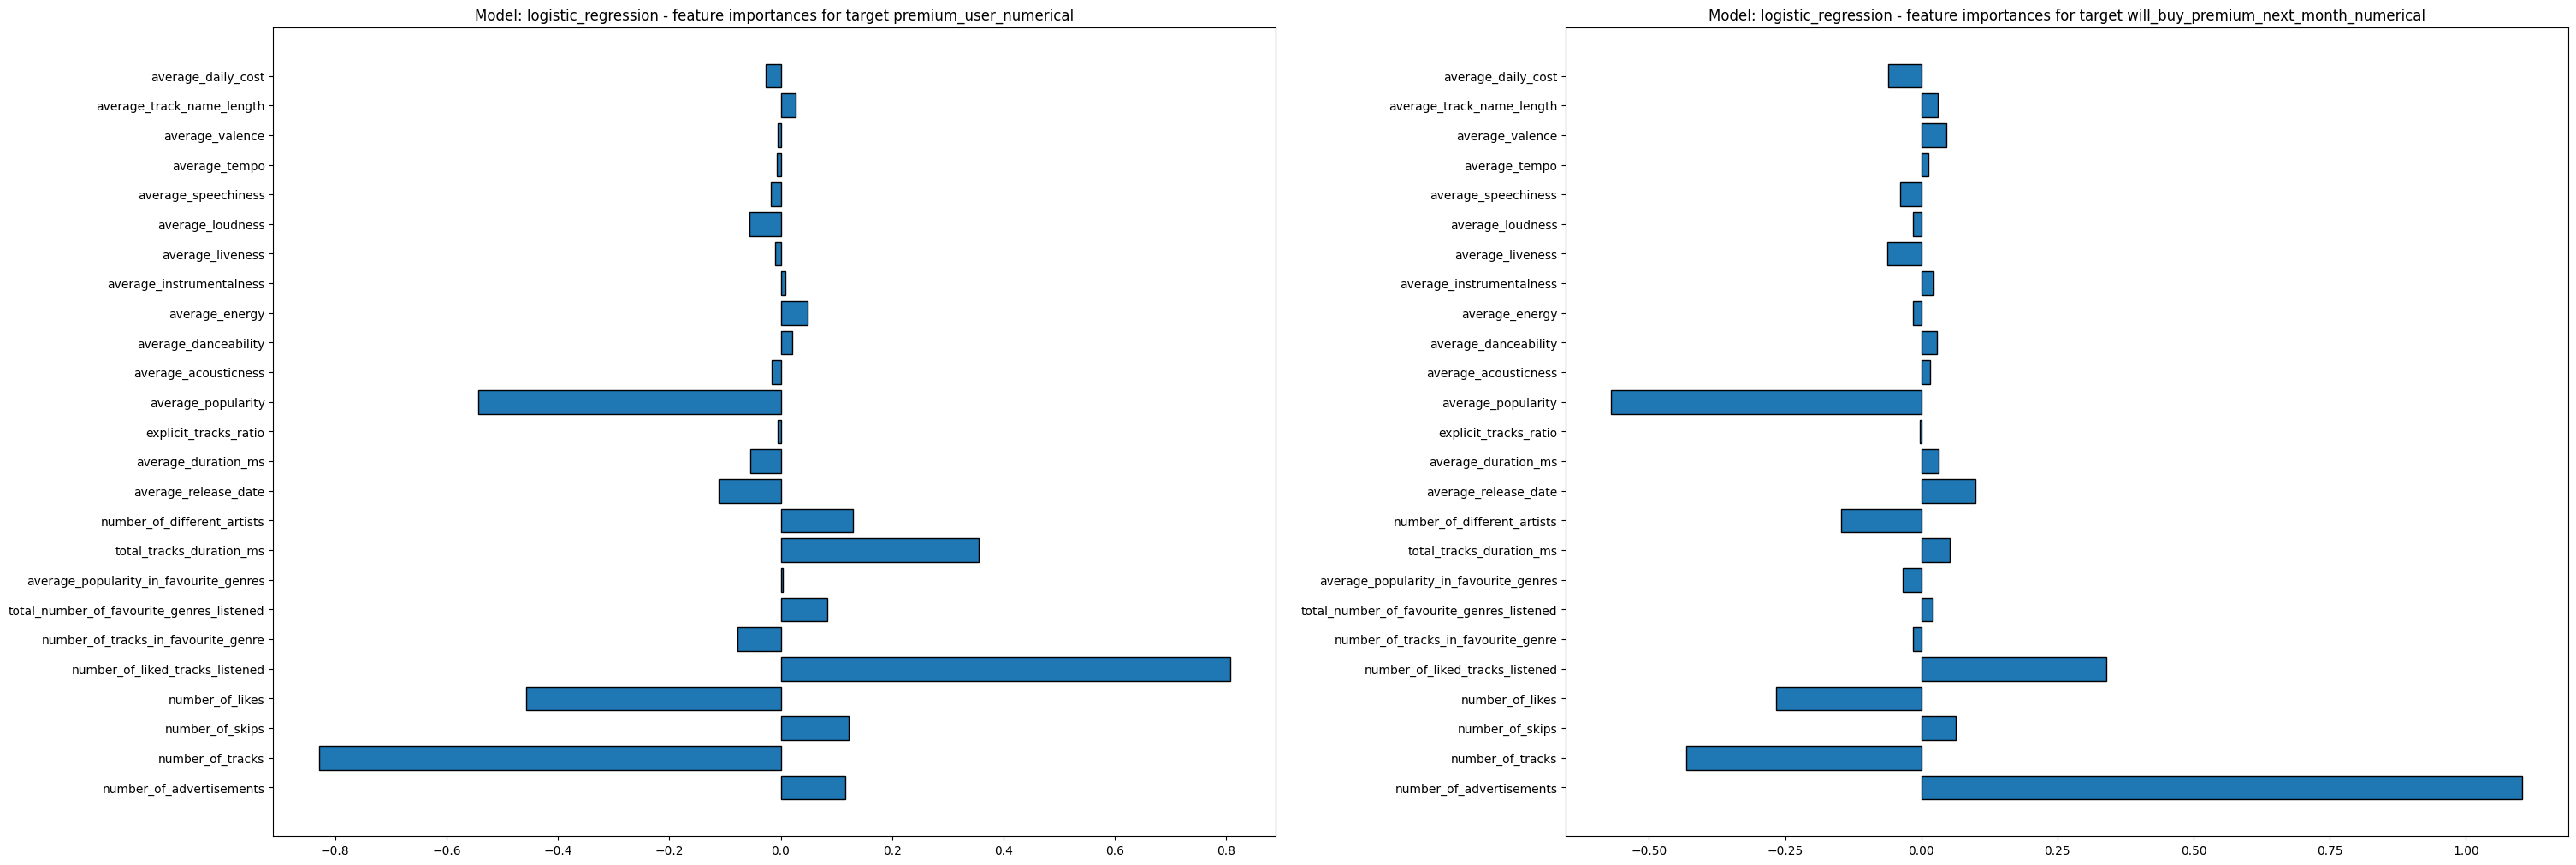

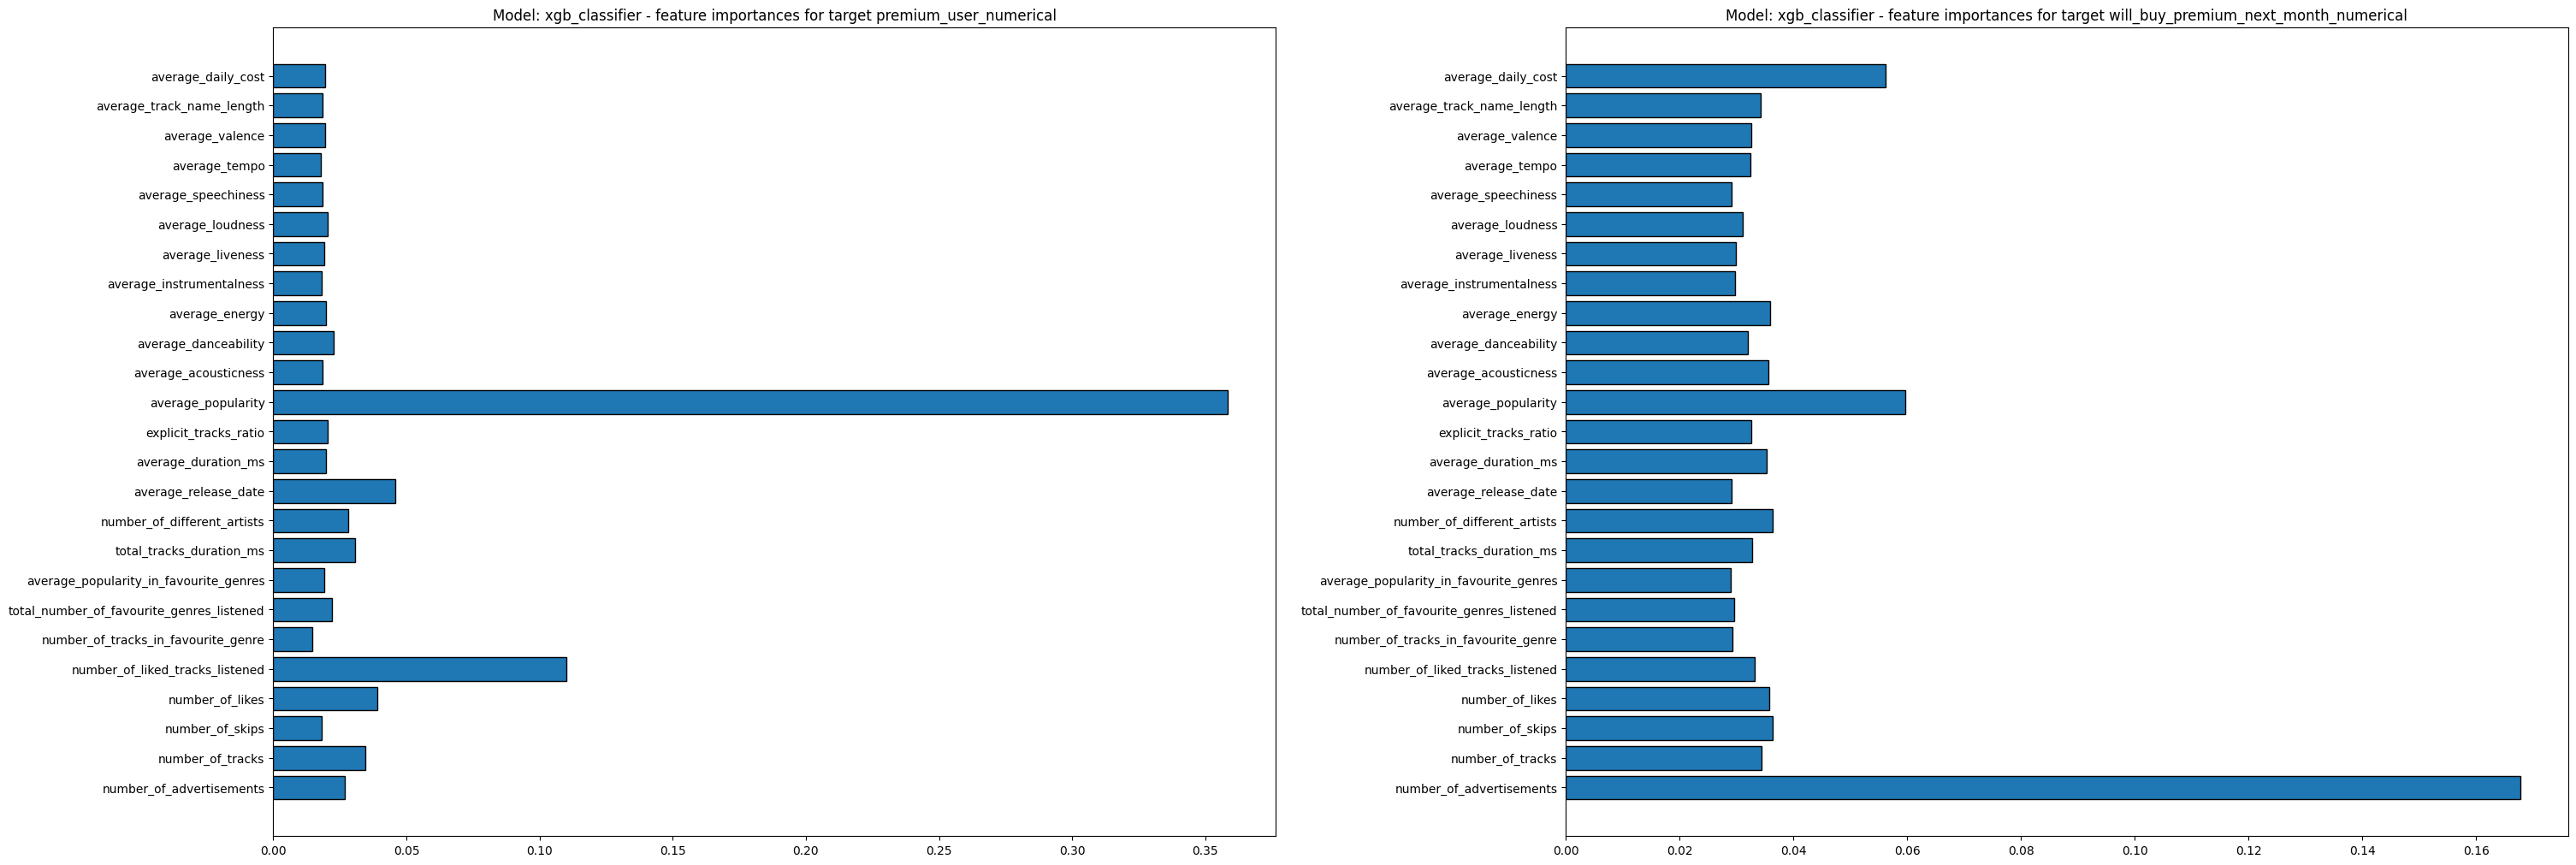

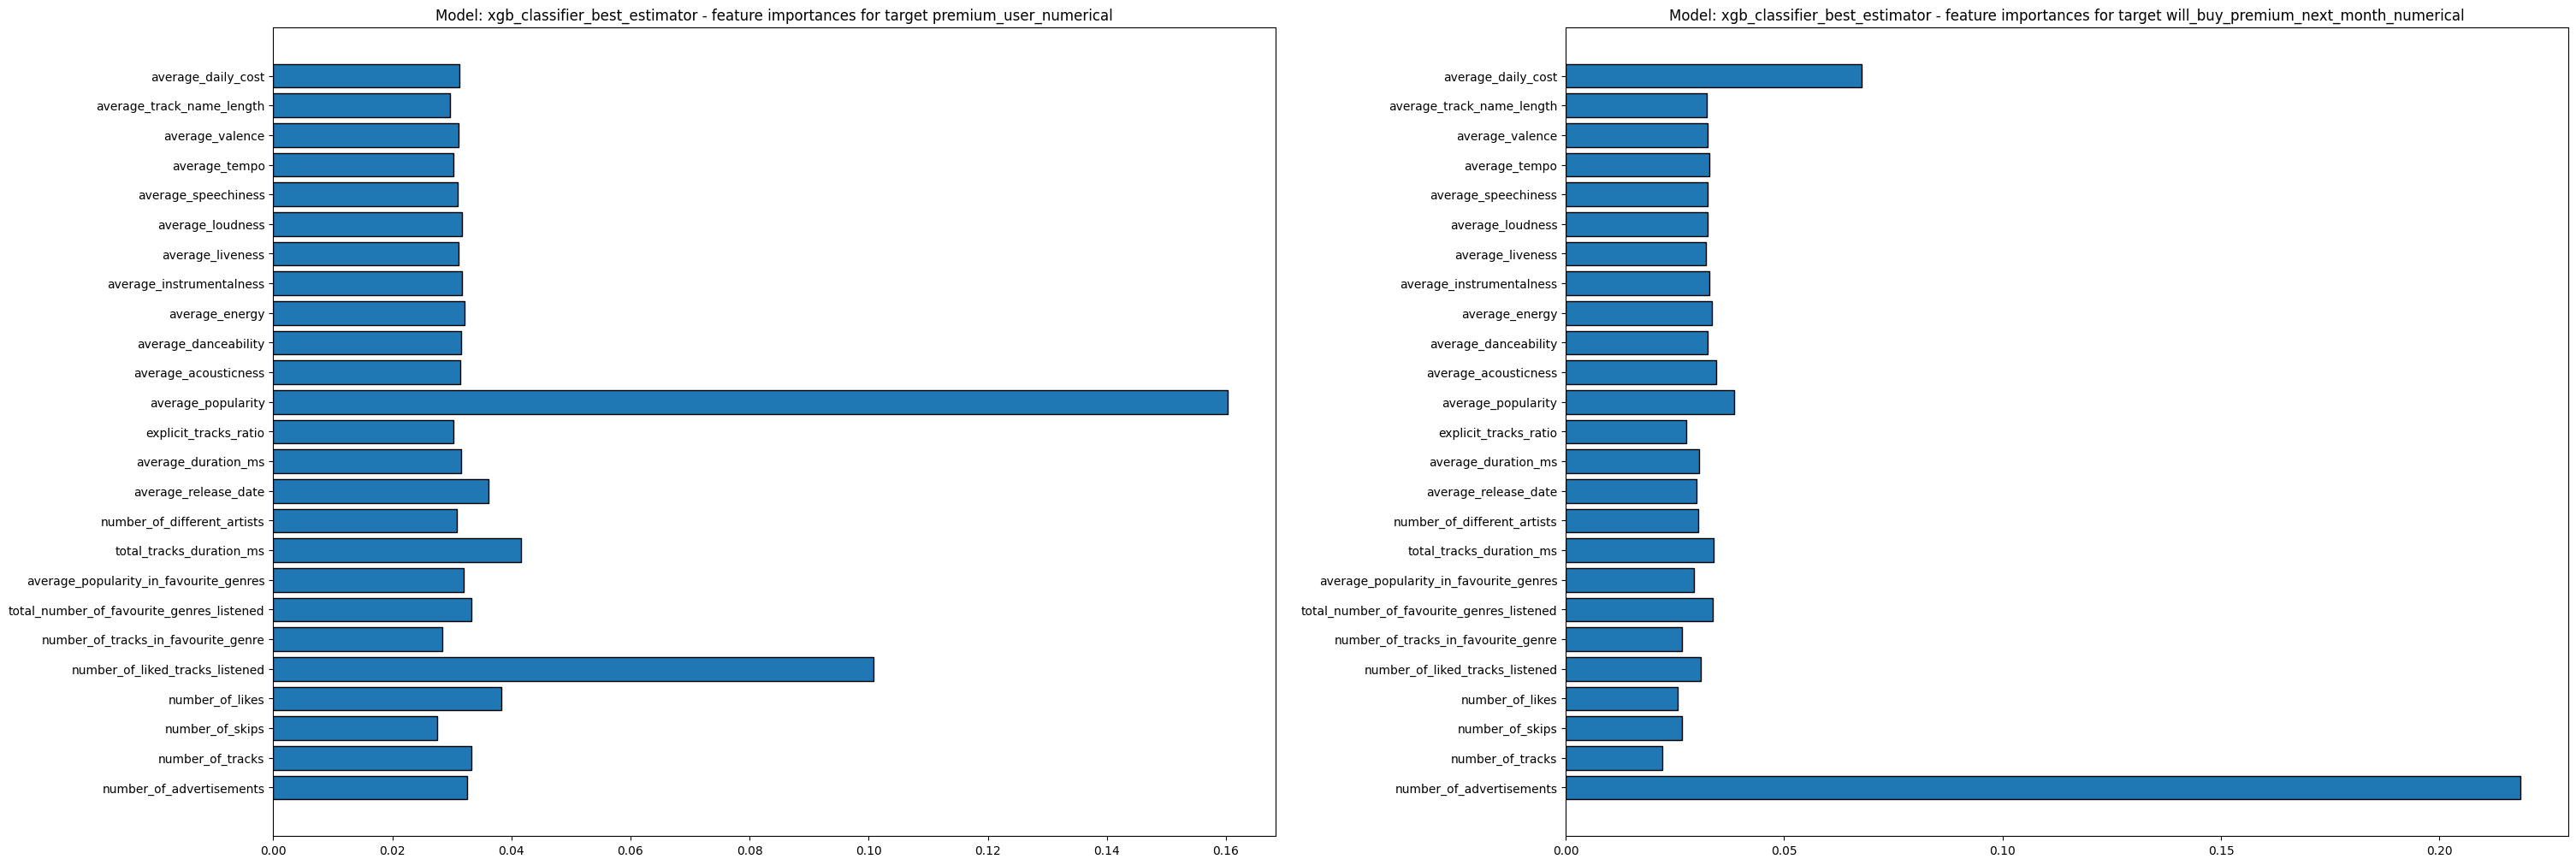

In [16]:
def retrieve_weights(model: Model) -> np.ndarray[np.float64]:
    if isinstance(model, LogisticRegression):
        return model.coef_[0]
    if isinstance(model, XGBClassifier):
        return model.feature_importances_
    return np.zeros(len(FEATURES))


for type in MODEL_TYPES:
    _, axs = plt.subplots(1, len(TARGETS), figsize=(
        30, 10), constrained_layout=True)
    for i, target in enumerate(TARGETS):
        model = MODELS[type][target]
        columns = FEATURES
        weights = retrieve_weights(model)
        axs[i].barh(y=columns, width=weights, edgecolor="black")
        axs[i].set_title(
            f"Model: {type} - feature importances for target {target}")
    plt.show()

In [17]:
# temp = 10
# plots = []
# MONTHS = 60
# subplots = [plt.subplots(4, MONTHS//4, figsize=(100, 40))
#             [1].flatten() for _ in TARGETS]
# plot_statistics = []
# for year, month in itertools.product(range(2019, 2023), range(1, 13)):
#     temp += 1
#     if temp % 10 != 0:
#         continue
#     data_train = data_frame.loc[
#         data_frame.apply(lambda x: x.year < year or (
#             x.month <= month and x.year == year), axis=1),
#         :
#     ]
#     if len(data_train) == 0:
#         continue
#     data_test = data_frame.loc[
#         data_frame.apply(lambda x: (x.month == month + 1 and x.year == year)
#                          or (x.year == year + 1 and x.month == 1), axis=1),
#         :
#     ]
#     x_train, y_train = data_train[FEATURES], data_train[TARGETS]
#     x_test, y_test = data_test[FEATURES], data_test[TARGETS]

#     plots.append(create_plot_from_model(x_train, y_train, x_test, y_test, [
#                  subplot[temp] for subplot in subplots], XGBClassifier, randomized_search_cv.best_params_))

# plt.show()

In [18]:
# TODO: F1 score, Precision, Recall figures

Eksperymenty A/B

In [19]:
def get_params(model: Model) -> Optional[Dict[str, Any]]:
    if isinstance(model, XGBClassifier):
        return model.get_params()
    return None


X_train = pd.DataFrame(
    pipeline.fit_transform(TRAIN_DATA[FEATURES]),
    columns=FEATURES
)
Y_train = TRAIN_DATA[TARGETS]
for type in MODEL_TYPES:
    estimators = {}
    for target in TARGETS:
        y_train = Y_train[target]
        estimators[target] = MODEL_CONSTRUCTORS[type](
            X_train, y_train, get_params(MODELS[type][target])
        )
    model = IUMModel(pipeline, estimators)
    with open(f'models/{type}.pkl', 'wb') as f:
        pickle.dump(model, f)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END eta=0.09526317154882966, gamma=0.1030937855884464, max_depth=28, n_estimators=81;, score=0.696 total time=15.7min
[CV 3/5] END eta=0.09526317154882966, gamma=0.1030937855884464, max_depth=28, n_estimators=81;, score=0.715 total time=15.8min
[CV 5/5] END eta=0.09526317154882966, gamma=0.1030937855884464, max_depth=28, n_estimators=81;, score=0.697 total time=15.8min
[CV 2/5] END eta=0.09526317154882966, gamma=0.1030937855884464, max_depth=28, n_estimators=81;, score=0.709 total time=15.8min
[CV 4/5] END eta=0.09526317154882966, gamma=0.1030937855884464, max_depth=28, n_estimators=81;, score=0.705 total time=15.8min


In [ ]:
random_premutation = np.random.permutation(TRAIN_DATA.index)
size = len(random_premutation) // len(MODEL_TYPES)

REALITIES: Dict[str, pd.DataFrame] = {}

for i, type in enumerate(MODEL_TYPES):
    indices = random_premutation[i * size:(i + 1) * size]
    REALITIES[type] = TRAIN_DATA.loc[indices]

In [ ]:
for type in MODEL_TYPES:
    display(REALITIES[type].head())

In [ ]:
result = {
    type: {
        target: pd.DataFrame({
            "guess": [],
            "ground_truth": [],
            "model": [],
            "year": [],
            "month": [],
            "user_id": [],
        })
        for target in TARGETS
    }
    for type in MODEL_TYPES
}

for type in MODEL_TYPES:
    url = f'http://127.0.0.1:5000/predict/{type}'
    for i in range(0, len(TEST_DATA)):
        row = TEST_DATA.iloc[i].to_dict()
        response = requests.post(url, json=row).json()
        for target in TARGETS:
            current = pd.DataFrame({
                "guess": [1 if response[target] else 0],
                "ground_truth": [row[target]],
                "model": [type],
                "year": [row['year']],
                "month": [row['month']],
                "user_id": [row['user_id']],
            })
            result[type][target] = pd.concat(
                [result[type][target], current], ignore_index=True
            )

In [ ]:
for type in MODEL_TYPES:
    print(type.upper())
    for target in TARGETS:
        print(target)
        print()
        print(result[type][target].guess.value_counts())
        print()
        print(result[type][target].ground_truth.value_counts())
        roc_auc_score_value = roc_auc_score(
            result[type][target].ground_truth, result[type][target].guess
        )
        print()
        print('ROC AUC score = ', roc_auc_score_value)
        print()

In [ ]:
for type in MODEL_TYPES:
    for target in TARGETS:
        result[type][target].to_csv(f'ab_experiment/{type}-{target}.csv')

In [ ]:
# np.random.seed(1234)

# print(f"{BUCKETS_CNT=}, {T_ALPHA=}")
# data = load_data()
# buckets_indices = get_buckets_indices(data.user_id.values)
# xgb_f1_score, logreg_f1_score = get_xgb_logreg_f1_scores(data, buckets_indices)
# print(f"{np.mean(xgb_f1_score)=}, {np.mean(logreg_f1_score)=}")
# s_p = get_s_p(xgb_f1_score, logreg_f1_score)
# t = get_t(xgb_f1_score, logreg_f1_score, s_p)
# print(f"{s_p=}, {t=}")
# if is_xgb_better(t):
#     print("XGBClassifier is better than LogisticRegression")
# else:
#     print("We can't say that XGBClassifier is better than LogisticRegression")